In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import glob
import cv2

from tools import config
from tools.ensemble_fuzzy_integrals import ensemble

In [3]:
datagenAug = ImageDataGenerator(
    rotation_range=90,
	zoom_range=0.15,
	horizontal_flip=True,
	vertical_flip=True,
	validation_split=0.2
)

testGen = datagenAug.flow_from_directory(
    config.DEFECTS_PATH, classes=config.CLASSES,
    target_size=(224, 224), class_mode="categorical",
    batch_size=32, subset="validation")

Found 2001 images belonging to 6 classes.


In [4]:
vgg = load_model(os.path.sep.join([config.OUTPUT_PATH, "vgg.model"]))
resnet = load_model(os.path.sep.join([config.OUTPUT_PATH, "resnet101.model"]))
inception = load_model(os.path.sep.join([config.OUTPUT_PATH, "inceptionV3.model"]))

In [5]:
vgg_predictions = list()
resnet_predictions = list()
inception_predictions = list()
    
for path in testGen.filepaths:
    image = cv2.imread(path)
    image = cv2.resize(image, (224, 224))
    image = np.expand_dims(image, axis=0)
    
    vgg_pred = vgg.predict(image)
    resnet_pred = resnet.predict(image)
    inception_pred = inception.predict(image)
    
    vgg_predictions.append(vgg_pred[0])
    resnet_predictions.append(resnet_pred[0])
    inception_predictions.append(inception_pred[0])

In [6]:
vgg_report = classification_report(
    testGen.classes, [arr.argmax(axis=0) for arr in vgg_predictions],
    target_names=config.CLASSES, output_dict=True
)

resnet_report = classification_report(
    testGen.classes, [arr.argmax(axis=0) for arr in resnet_predictions],
    target_names=config.CLASSES, output_dict=True
)

inception_report = classification_report(
    testGen.classes, [arr.argmax(axis=0) for arr in inception_predictions],
    target_names=config.CLASSES, output_dict=True
)

In [ ]:
accuracy_models = {
    "resnet101" : resnet_report['accuracy'],
    "vgg16" : vgg_report['accuracy'],
    "inceptionv3" : inception_report['accuracy']
}

with open(os.path.sep.join([config.OUTPUT_PATH, "accuracy_models.pkl"]), "wb") as f:
    pickle.dump(accuracy_models, f)

In [6]:
with open(os.path.sep.join([config.OUTPUT_PATH, "accuracy_models.pkl"]), "rb") as f:
    accuracy_models = pickle.load(f)
    
measures = [accuracy_models["vgg16"], accuracy_models["resnet101"], accuracy_models["inceptionv3"]]

In [10]:
sugeno_predictions = list()
for i in range(len(testGen.classes)):
    pred = ensemble([vgg_predictions[i], resnet_predictions[i], inception_predictions[i]], measures, mode='sugeno')
    sugeno_predictions.append(pred)
    
print(classification_report(testGen.classes,
    sugeno_predictions, target_names=testGen.class_indices, digits=3))

              precision    recall  f1-score   support

        open      0.982     0.990     0.986       388
       short      0.970     0.977     0.974       301
    mousebit      0.970     0.985     0.977       393
        spur      0.990     0.957     0.973       325
      copper      0.997     1.000     0.998       294
    pin-hole      0.990     0.987     0.988       300

    accuracy                          0.983      2001
   macro avg      0.983     0.982     0.983      2001
weighted avg      0.983     0.983     0.982      2001



In [13]:
choquet_predictions = list()
for i in range(len(testGen.classes)):
    pred = ensemble([vgg_predictions[i], resnet_predictions[i], inception_predictions[i]], measures)
    choquet_predictions.append(pred)
    
print(classification_report(testGen.classes,
    choquet_predictions, target_names=testGen.class_indices, digits=3))

              precision    recall  f1-score   support

        open      0.995     0.995     0.995       388
       short      0.952     0.997     0.974       301
    mousebit      0.982     0.980     0.981       393
        spur      0.997     0.960     0.978       325
      copper      1.000     1.000     1.000       294
    pin-hole      0.990     0.987     0.988       300

    accuracy                          0.986      2001
   macro avg      0.986     0.986     0.986      2001
weighted avg      0.986     0.986     0.986      2001



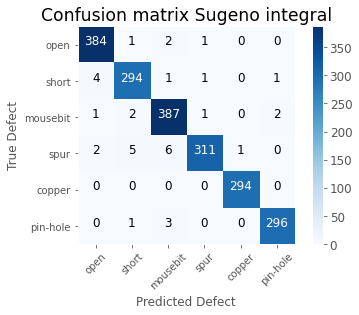

In [11]:
import itertools

plt.style.use("ggplot")
plt.grid(False)
plt.rcParams["figure.figsize"] = (8,6)
font = {'size' : 12}
plt.rc('font', **font)

cm = confusion_matrix(testGen.classes, sugeno_predictions)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(testGen.class_indices))

plt.xticks(tick_marks, testGen.class_indices, rotation=45)
plt.yticks(tick_marks, testGen.class_indices)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted Defect')
plt.ylabel('True Defect')
plt.title('Confusion matrix Sugeno integral')
plt.savefig('output/sugeno_confusion_matrix.png')
plt.show()

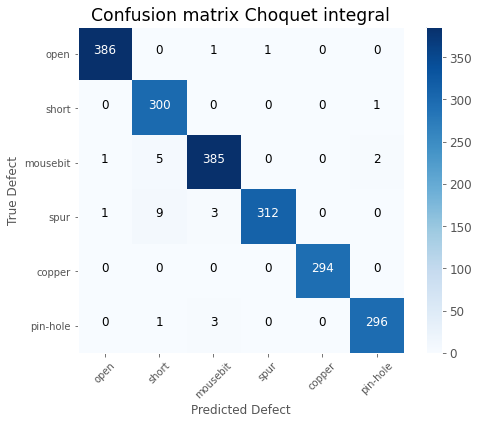

In [15]:
import itertools

plt.style.use("ggplot")
plt.grid(False)
plt.rcParams["figure.figsize"] = (8,6)
font = {'size' : 12}
plt.rc('font', **font)

cm = confusion_matrix(testGen.classes, choquet_predictions)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(testGen.class_indices))

plt.xticks(tick_marks, testGen.class_indices, rotation=45)
plt.yticks(tick_marks, testGen.class_indices)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted Defect')
plt.ylabel('True Defect')
plt.title('Confusion matrix Choquet integral')
plt.savefig('output/choquet_confusion_matrix.png')
plt.show()

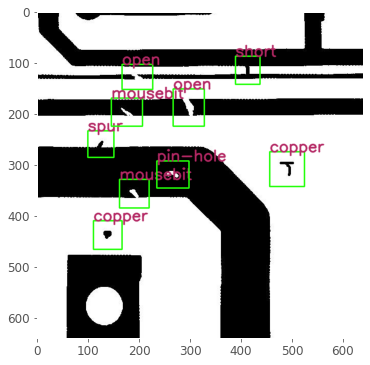

In [16]:
from tools import defect_detection

defects = defect_detection.get_defects_list(f"{config.DATASET_PATH}/group00041/00041/00041086_test.jpg",
                                            f"{config.DATASET_PATH}/group00041/00041/00041086_temp.jpg")
img = defect_detection.get_image_with_ROI(f"{config.DATASET_PATH}/group00041/00041/00041086_test.jpg", defects)
plt.grid(False)
plt.imshow(img)